In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from kmodes import kmodes
from sklearn.cluster import KMeans
from matplotlib import pyplot
import pylab as pl
from sklearn.decomposition import PCA
import random
from scipy.spatial.distance import cdist,pdist
moviesdf = pd.read_csv('./ml100k/u.item', header=None,sep='|')
moviesdf1 = pd.read_csv('./ml100k/movies.csv')
ratingsdf = pd.read_csv('./ml100k/ratings.csv')
ratingsdf=ratingsdf.groupby('movieId').filter(lambda x: len(x) >= 10)
ratingsdf=ratingsdf.reset_index(drop=True)

In [2]:
cols_to_be_repeated = ["movieId", "title"]
splitdf = lambda x: x.split('|')
s = moviesdf1.genres.str.split("|").apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
del moviesdf1['genres']
moviesdfnew=moviesdf1.join(pd.DataFrame(s))



In [3]:
moviesdfnew.columns = ['movieId','title','genres']


In [4]:
df=pd.get_dummies(moviesdfnew['genres'])

In [5]:
moviesdf2=df.groupby(df.index).sum()
movies=moviesdf1.join(moviesdf2, lsuffix='_moviesdf1', rsuffix='_moviedsf2')

In [6]:

titles = movies
titles1 = titles.drop(titles.columns[[0, 1]], axis=1, inplace=True)
titles1 = titles.as_matrix()


In [7]:
def withinss(km): 
    centroids =(km.cluster_centroids_)
    D_k = [cdist(titles, centroids, 'jaccard')]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/titles.shape[0] for d in dist]
    return avgWithinSS




In [8]:
def clusterFilms(titles):
    random.seed(101)
    i = 1
    while(1):
        i = i+1
        movieCluster1 = kmodes.KModes(n_clusters=i, init='Huang', n_init=1, verbose=1).fit(titles)
        movieCluster2 = kmodes.KModes(n_clusters=i+1, init='Huang', n_init=1, verbose=1).fit(titles)
        ss1 = withinss(movieCluster1)
        ss2 = withinss(movieCluster2)
        print ss1
         #decision criterion
        dss = (ss1[0]-ss2[0])/ss1[0]
        #exit if dss < 0.2
        if (dss < 0.2):
            pca = PCA(n_components=i).fit(titles)
            pca_2d = pca.transform(titles)
            print pca_2d
            for j in range(0, pca_2d.shape[0]):
                if movieCluster1.labels_[j] == 0:
                     c1 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='r',
                     marker='+')
                if movieCluster1.labels_[j]==1:
                      c2 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='b',
                     marker='*')
                if movieCluster1.labels_[j]==2:
                      c2 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='g',
                     marker='o')
            pl.show()
            print("no of cluster ",i)
            break
    return(movieCluster1)
        

In [9]:
#moviecluster=clusterFilms(titles)

#ratingsdf.head()
def getUserInfo(ratingsdf,id):
    df = ratingsdf[ratingsdf.userId == 3][['movieId','rating']]
    a=pd.DataFrame(df.sort('movieId'))
    a=a.reset_index(drop=True)    
    return a


In [10]:
def setcluster(moviecluster,a):
    df1=pd.DataFrame(moviesdf1.movieId)
    df1['clusterno'] = moviecluster.labels_
    df2 = df1[df1.movieId.isin(a.movieId)]
    df2=df2.reset_index(drop=True)
    a['cluster']=df2.clusterno

    return a

In [11]:
def getmeanratings(a):
    b=pd.DataFrame(a.groupby(a.cluster)['rating'].mean())
    
    c = b[b.rating==max(b.rating)].index
    return c


In [12]:
def getrecommendedfilms(c,moviecluster,moviesdf1,a,ratingsdf):
    df1=pd.DataFrame(moviesdf1.movieId)
    df1['clusterno'] = moviecluster.labels_
    df3=df1[df1.clusterno.isin(c)][['movieId']]
    df3 = df3.reset_index(drop=True)
    df3 = df3[~df3.movieId.isin(a.movieId)]
    df3 = df3.reset_index(drop=True)
    d = ratingsdf[ratingsdf.movieId.isin(df3.movieId)]
#b=pd.DataFrame(a.groupby(a.cluster)['rating'].mean())
    d = d.reset_index(drop=True)
    r=pd.DataFrame(d.groupby(d.movieId)['rating'].mean())
    t=moviesdf1[moviesdf1.movieId.isin(r.index)]['title']
    t.index = r.index
    r['title']=t
    return r.sort_values(by='rating',ascending=False)


In [13]:
def recommend(titles,moviesdf1,ratingsdf,userid,number):
    moviecluster = clusterFilms(titles)
    activeuser = getUserInfo(ratingsdf,userid)
    activeuser = setcluster(moviecluster,activeuser)
    cluster = getmeanratings(activeuser)
    recommend = getrecommendedfilms(cluster,moviecluster,moviesdf1,activeuser,ratingsdf)
    top = recommend.head(n = 50)
    
    return top.sample(number)
    

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 539, cost: 19106.0
Run 1, iteration: 2/100, moves: 0, cost: 19106.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1332, cost: 16162.0
Run 1, iteration: 2/100, moves: 0, cost: 16162.0
[0.79541169819527513]
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 604, cost: 13845.0
Run 1, iteration: 2/100, moves: 0, cost: 13845.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 13798.0
[0.51503718199608572]
[[ 1.09985494  0.20148563  0.88636903]
 [ 0.36644962  0.50409248  0.98101826]
 [ 0.82587562 -0.50183833 -0.21796187]
 ..., 
 [ 0.13989724  0.21987121  0.07400134]
 [ 0.77189203 -0.16758386 -0.22377276]
 [ 0.13989724  0.21987121  0.07400134]]


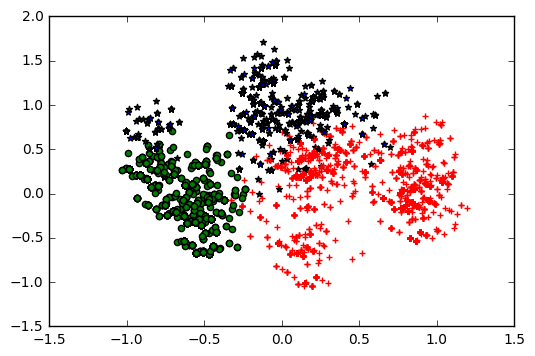

('no of cluster ', 3)


c:\python27\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,rating,title
movieId,,
48516,4.202381,"Departed, The (2006)"
1209,4.218750,Once Upon a Time in the West (C'era una volta ...
912,4.235043,Casablanca (1942)
2019,4.277778,Seven Samurai (Shichinin no samurai) (1954)
3983,4.250000,You Can Count on Me (2000)
1193,4.256944,One Flew Over the Cuckoo's Nest (1975)
2186,4.260870,Strangers on a Train (1951)
3469,4.541667,Inherit the Wind (1960)
2467,4.239130,"Name of the Rose, The (Name der Rose, Der) (1986)"


In [14]:
recommend(titles,moviesdf1,ratingsdf,3,10)
